In [1]:
import pandas as pd
Signupdata = pd.read_csv('/home/mvisi/Project/DLP/Core/FraudPredict/Notebook/Arpan/Signupdataimputed.csv', error_bad_lines=False)

In [2]:
#Seperating Dependent and independent variables 
#data_final_Org= data_final.copy()
Signupdata_ML = Signupdata.copy()
X_Signupdata = Signupdata.drop(['Fraud_Acc_Flag'], axis=1, inplace=True)
Y_Signupdata = Signupdata_ML.Fraud_Acc_Flag

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Signupdata, Y_Signupdata, test_size=0.30, random_state=42)

In [4]:
#HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
gbc=HistGradientBoostingClassifier(learning_rate=0.01, 
        max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
        n_iter_no_change=15, random_state=42).fit(X_train,y_train)

In [5]:
from sklearn import model_selection, metrics
hardpredtst=gbc.predict(X_test)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
conf_matrix(y_test,hardpredtst)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 124709 (TNR = 100.00%),FP = 2 (FPR = 0.00%)
True 1(Fraud),FN = 236 (FNR = 99.58%),TP = 1 (TPR = 0.42%)


# We see that the Recall for Class 1 (Sensitivity or True Positive Rate shown as TPR above) is only 0.42%, meaning that 0.42% of the true frauds are correctly identified as frauds and thus denied. So 99.58% of the true frauds are unfortunately approved as if legitimate

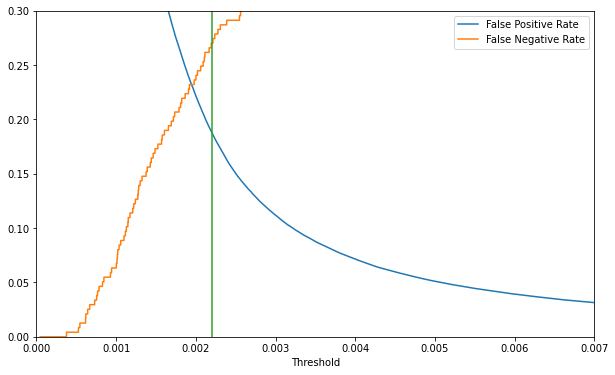

In [29]:
predtst=gbc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predtst)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.0022,0.0022],[0,0.3]) #mark example thresh.
ax.set_xbound(0,0.0070); ax.set_ybound(0,0.3) 

In [34]:
import numpy as np
hardpredtst_tuned_thresh = np.where(predtst >= 0.0022, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_thresh)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 101258 (TNR = 81.19%),FP = 23453 (FPR = 18.81%)
True 1(Fraud),FN = 64 (FNR = 27.00%),TP = 173 (TPR = 73.00%)


In [4]:
#Applying XGBoost Classification
import xgboost as xgb
XGBClassifier = xgb.XGBClassifier()
XGBClassifier.fit(X_train,y_train)

/home/mvisi/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:23:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
from sklearn import model_selection, metrics
hardpredtst=XGBClassifier.predict(X_test)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
conf_matrix(y_test,hardpredtst)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 124700 (TNR = 99.99%),FP = 11 (FPR = 0.01%)
True 1(Fraud),FN = 221 (FNR = 93.25%),TP = 16 (TPR = 6.75%)


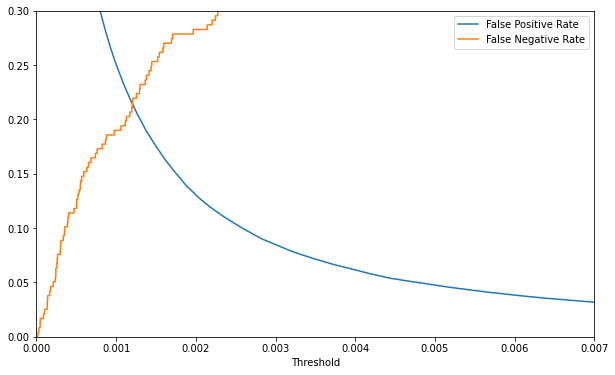

In [6]:
predtstXGBC=XGBClassifier.predict_proba(X_test)[:,1] #rerun again
fpr, tpr, thresholds = metrics.roc_curve(y_test, predtstXGBC)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
#ax.plot([0.00035,0.00035],[0,0.1]) #mark example thresh.
ax.set_xbound(0,0.0070); ax.set_ybound(0,0.3) 

In [7]:
import numpy as np
hardpredtst_tuned_threshXGBC = np.where(predtstXGBC >= 0.0012035066029056907, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_threshXGBC
        )

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 97986 (TNR = 78.57%),FP = 26725 (FPR = 21.43%)
True 1(Fraud),FN = 51 (FNR = 21.52%),TP = 186 (TPR = 78.48%)


In [78]:
#0.007600000000000007
hardpredtst_tuned_threshXGBC = np.where(predtstXGBC >= 0.003600000000000007, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_threshXGBC)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 116077 (TNR = 93.08%),FP = 8634 (FPR = 6.92%)
True 1(Fraud),FN = 86 (FNR = 36.29%),TP = 151 (TPR = 63.71%)


In [72]:
predtstXGBC

array([1.9637539e-05, 3.1839756e-03, 3.3025008e-02, ..., 1.1867509e-04,
       8.3018705e-04, 2.1087856e-03], dtype=float32)

In [8]:
#Hypertuning the XGBClassifier
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "eval_metric"      : ["aucpr"],
"objective"      : ["binary:logistic"]
#"scale_pos_weight"  : [1, 10, 25, 50, 75, 99, 100, 200]
    
}
print (params)

{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7], 'eval_metric': ['aucpr'], 'objective': ['binary:logistic']}


In [9]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [10]:
XGBClassifier = xgb.XGBClassifier()
random_searchCV=RandomizedSearchCV(XGBClassifier,param_distributions=params,n_iter=7,scoring='f1_macro',n_jobs=-1,#cv=4,
                                 refit=True,cv=cv,
                                 verbose=3)

In [82]:
random_searchCV.fit(X_train, y_train)

Fitting 30 folds for each of 7 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 50.5min finished
/home/mvisi/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weigh...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=7, n_jobs=-1,
                   par

In [83]:
random_searchCV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [11]:
#Applying hypertuned XGBoost
XGBClassifiertuned = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=15, min_child_weight=1, 
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
XGBClassifiertuned.fit(X_train,y_train)


/home/mvisi/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='aucpr',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [12]:
from sklearn import model_selection, metrics
hardpredtst=XGBClassifiertuned.predict(X_test)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
conf_matrix(y_test,hardpredtst)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 124704 (TNR = 99.99%),FP = 7 (FPR = 0.01%)
True 1(Fraud),FN = 212 (FNR = 89.45%),TP = 25 (TPR = 10.55%)


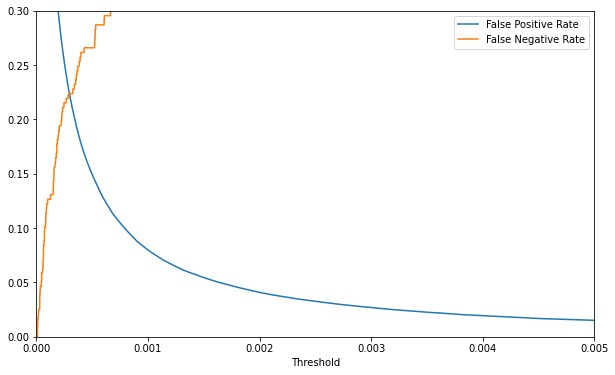

In [13]:
predtstXGBCT=XGBClassifiertuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predtstXGBCT)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
#ax.plot([0.0022,0.0022],[0,0.3]) #mark example thresh.
ax.set_xbound(0,0.005); ax.set_ybound(0,0.3) #zoom in

In [14]:
from sklearn.metrics import roc_curve

In [17]:
#for XGBClassifer
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(y_test, predtstXGBC)
    i = np.arange(len(tpr)) 
    # tpr -(1-fpr) is zero near the optimal point
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']),roc

In [22]:
from sklearn.metrics import roc_curve
Optimal_Cutoff,roc = Find_Optimal_Cutoff(y_test.values, predtstXGBC)
print (Optimal_Cutoff)

[0.000296951417112723]


In [23]:
#for tuned XGBClassifer
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(y_test, predtstXGBCT)
    i = np.arange(len(tpr)) 
    # tpr -(1-fpr) is zero near the optimal point
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']),roc

In [24]:
Optimal_Cutoff,roc = Find_Optimal_Cutoff(y_test.values, predtstXGBCT)
print (Optimal_Cutoff)

[0.000296951417112723]


In [25]:
hardpredtst_tuned_threshXGBCT = np.where(predtstXGBCT >= 0.000296951417112723, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_threshXGBCT)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 96910 (TNR = 77.71%),FP = 27801 (FPR = 22.29%)
True 1(Fraud),FN = 53 (FNR = 22.36%),TP = 184 (TPR = 77.64%)


In [93]:
XGBClassifiertuned.predict_proba(X_test)[:,1]

array([1.7061473e-04, 8.1319711e-05, 9.0411808e-03, ..., 1.3887111e-04,
       4.5958729e-04, 1.8180859e-04], dtype=float32)

In [70]:
y_test.values

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
#The best hyperparameters:
param = {'alpha': 9.0,
 'colsample_bytree': 0.75,
 'eta': 0.25,
 'gamma': 0.9,
 'lambda': 1.1,
 'max_depth': 11,
 'min_child_weight': 6.0,
 'scale_pos_weight': 350.0,
 'subsample': 0.7000000000000001}

In [37]:
#Hyperparameter tuned XGBOOST with previous paramaters
import xgboost as xgb
#XGBClassifier = xgb.XGBClassifier()
XGBClassifiertunedold = xgb.XGBClassifier(**param)
XGBClassifiertunedold.fit(X_train,y_train)



[14:17:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=9.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, eta=0.25, gamma=0.9,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1.1, learning_rate=0.25, max_delta_step=0, max_depth=11,
              min_child_weight=6.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=9, reg_lambda=1.10000002, scale_pos_weight=350.0,
              subsample=0.7000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [38]:
from sklearn import model_selection, metrics
hardpredtstold=XGBClassifiertunedold.predict(X_test)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
conf_matrix(y_test,hardpredtstold)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 124521 (TNR = 99.85%),FP = 190 (FPR = 0.15%)
True 1(Fraud),FN = 168 (FNR = 70.89%),TP = 69 (TPR = 29.11%)


In [39]:
predtstXGBCTold=XGBClassifiertunedold.predict_proba(X_test)[:,1]
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(y_test, predtstXGBCTold)
    i = np.arange(len(tpr)) 
    # tpr -(1-fpr) is zero near the optimal point
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']),roc

In [40]:
Optimal_Cutoff,roc = Find_Optimal_Cutoff(y_test.values, predtstXGBCTold)
print (Optimal_Cutoff)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


[0.0020802586805075407]


In [41]:
hardpredtst_tuned_threshXGBCTold = np.where(predtstXGBCTold >= 0.0020802586805075407, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_threshXGBCTold)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 96417 (TNR = 77.31%),FP = 28294 (FPR = 22.69%)
True 1(Fraud),FN = 54 (FNR = 22.78%),TP = 183 (TPR = 77.22%)


# XGBClassifier gave the similar result even compared to Tuned XGBClasifier with Dynamic Threshold cutoff generation

In [ ]:
# Testing hyperparameter tuned XGBoost with Randomoversample data

# Checking interpretability using Shapash library

In [16]:
pip install --trusted-host pypi.org --default-timeout=100 --trusted-host files.pythonhosted.org shapash

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 841 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 11.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 326 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 642 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 188 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.1 MB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 10.3 MB/s ta 0:00:011
     |████████████████████████████████| 2

  Created wheel for dash-html-components: filename=dash_html_components-1.1.1-py3-none-any.whl size=427893 sha256=9a60b2547d9ba4358f89bf2da6a15829d5186d4ea07ada8610fa95d980bc9537
  Stored in directory: /home/mvisi/.cache/pip/wheels/ff/d9/16/e059d112e0d37928fda032fd33eb0fb8507a584bf903c8ee20
  Created wheel for dash: filename=dash-1.17.0-py3-none-any.whl size=83727 sha256=75d1299d0a899138b83258fddbb841702c2d3397045e4ad0f0aff049003ce9ed
  Stored in directory: /home/mvisi/.cache/pip/wheels/23/b4/5a/19beaeac2967da33d9e4270af894b7852f932f6136dd1c2beb
Successfully built dash-bootstrap-components shap dash-table dash-renderer dash-core-components dash-daq dash-html-components dash
  Attempting uninstall: plotly
    Found existing installation: plotly 4.14.3
    Uninstalling plotly-4.14.3:
      Successfully uninstalled plotly-4.14.3
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: llvmlite
    Found exi

In [15]:
#import shapash
from shapash.explainer.smart_explainer import SmartExplainer

/home/mvisi/.local/lib/python3.6/site-packages/numba/core/errors.py:149: UserWarning:

Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9



In [16]:
label_dict = {0: "Non-Fraud", 1: "Fraud"}

In [17]:
xpl = SmartExplainer(label_dict=label_dict) # optional parameter, specifies label for features name

In [18]:
hardpredtst_tuned_threshXGBC_Pandas = pd.DataFrame(hardpredtst_tuned_threshXGBC, columns=['pred'], #index=X_test.reset_index(drop='True'))  
                                                   index=X_test.index)


In [19]:
hardpredtst_tuned_threshXGBC_Pandas.head()

,pred
226589,0
123932,1
413136,1
354965,0
84563,0


In [38]:
hardpredtst_tuned_threshXGBC_Pandas.filter(like ='123932', axis =0)

,pred
123932,1


In [48]:
X_test.head()

,EIDStatus,SanctionStatus,Ip_Latitude,Ip_Longitude,Ip_Carrier,Ip_Connection_type,Ip_Line_Speed,Ip_Routing_type,IP_Anonymizer_status,Fullcontact_Matched,...,channel,keywords,op_country,referral_text,reg_mode,search_engine,source,sub_source,turnover,txn_value
226589,0,0,51.511111,-0.040000,865,11,1,3,0,1,...,1,0,0,0,0,0,3,276,25176.64,0
123932,0,0,-43.546470,172.236600,5805,4,3,3,0,0,...,1,0,0,0,0,0,16,276,0.00,15
413136,0,0,51.533000,-0.267000,6476,8,2,5,0,0,...,1,0,0,6327,3,0,16,283,0.00,110
354965,0,0,40.896111,29.190277,5792,1,3,3,0,1,...,1,0,0,0,3,0,3,276,0.00,118
84563,0,0,53.387222,-1.428611,867,4,3,3,0,1,...,1,1777,0,0,0,619,40,195,0.00,24


In [20]:
xpl.compile(
    x=X_test,
    model=XGBClassifier,
    y_pred=hardpredtst_tuned_threshXGBC_Pandas
)

ValueError: No attribute _classes, classification model not supported

In [41]:
xpl.to_pandas(max_contrib=3).head()

AttributeError: 'SmartExplainer' object has no attribute 'y_pred'

In [162]:
app = xpl.run_app(title_story='Fraud Prediction')


Dash is running on http://0.0.0.0:8050/



Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
INFO:root:Your Shapash application run on http://CD-ML-GPU:8050/


Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: UAT
 * Debug mode: off


Exception in thread Thread-791:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/mvisi/.local/lib/python3.6/site-packages/shapash/utils/threading.py", line 29, in __run
    self.__run_backup()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mvisi/.local/lib/python3.6/site-packages/shapash/explainer/smart_explainer.py", line 916, in <lambda>
    target=lambda: self.smartapp.app.run_server(debug=False, host=host, port=port))
  File "/home/mvisi/.local/lib/python3.6/site-packages/dash/dash.py", line 1716, in run_server
    self.server.run(host=host, port=port, debug=debug, **flask_run_options)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 944, in run
    run_simple(host, port, self, **options)
  File "/usr/local/lib/python3.6/dist-packages/werkzeug/serving.py", line 1010, in run_simple
    inner()
  File "/usr/lo

In [148]:
app.kill()

In [146]:
#https://shapash.readthedocs.io/en/latest/tutorials/tuto-plot04-compare_plot.html#classification-case

xpl.plot.compare_plot(row_num=[0, 1]) 

In [1]:
xpl.plot.local_plot(index=123932)

NameError: name 'xpl' is not defined

In [99]:
df2.filter(like = '123932', axis=0)

,EIDStatus,SanctionStatus,Ip_Latitude,Ip_Longitude,Ip_Carrier,Ip_Connection_type,Ip_Line_Speed,Ip_Routing_type,IP_Anonymizer_status,Fullcontact_Matched,...,op_country,referral_text,reg_mode,search_engine,source,sub_source,turnover,txn_value,Fraud_Acc_Flag,pred
123932,0,0,51.511111,-0.04,865,11,1,3,0,0,...,0,0,0,0,32,399,0.0,0,0,0


In [103]:
X_test.filter(like = '123932', axis=0)

,EIDStatus,SanctionStatus,Ip_Latitude,Ip_Longitude,Ip_Carrier,Ip_Connection_type,Ip_Line_Speed,Ip_Routing_type,IP_Anonymizer_status,Fullcontact_Matched,...,channel,keywords,op_country,referral_text,reg_mode,search_engine,source,sub_source,turnover,txn_value
123932,0,0,-43.54647,172.2366,5805,4,3,3,0,0,...,1,0,0,0,0,0,16,276,0.0,15


In [22]:
X_test_copy = X_test.copy()
X_test_copy['Fraud_Actual'] = y_test
X_test_copy['Fraud_Predict'] = hardpredtst_tuned_threshXGBC

In [109]:
X_test_copy.head()

,EIDStatus,SanctionStatus,Ip_Latitude,Ip_Longitude,Ip_Carrier,Ip_Connection_type,Ip_Line_Speed,Ip_Routing_type,IP_Anonymizer_status,Fullcontact_Matched,...,op_country,referral_text,reg_mode,search_engine,source,sub_source,turnover,txn_value,Fraud_Actual,Fraud_Predict
226589,0,0,51.511111,-0.040000,865,11,1,3,0,1,...,0,0,0,0,3,276,25176.64,0,0,0
123932,0,0,-43.546470,172.236600,5805,4,3,3,0,0,...,0,0,0,0,16,276,0.00,15,0,1
413136,0,0,51.533000,-0.267000,6476,8,2,5,0,0,...,0,6327,3,0,16,283,0.00,110,0,1
354965,0,0,40.896111,29.190277,5792,1,3,3,0,1,...,0,0,3,0,3,276,0.00,118,0,0
84563,0,0,53.387222,-1.428611,867,4,3,3,0,1,...,0,0,0,619,40,195,0.00,24,0,0


In [110]:
X_test_copy.to_csv('thresholdoutputcompare.csv')

In [28]:
pd.set_option('display.max_rows', None)
X_test_copy.filter(like='412759', axis=0)

,EIDStatus,SanctionStatus,Ip_Latitude,Ip_Longitude,Ip_Carrier,Ip_Connection_type,Ip_Line_Speed,Ip_Routing_type,IP_Anonymizer_status,Fullcontact_Matched,...,op_country,referral_text,reg_mode,search_engine,source,sub_source,turnover,txn_value,Fraud_Actual,Fraud_Predict
412759,0,0,37.33053,-121.83823,1342,11,1,3,0,0,...,0,228,2,0,32,92,0.0,24,1,1
